In [1]:
import sys
sys.path.append('../')

import numpy as np
import random
import torch
import gpytorch
from gp_mjo.gp_mjo_model import gp_mjo
from gp_mjo.utils.dat_ops import dics_divide

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
npzfile = np.load('../data/mjo_new_data.npz', allow_pickle=True)

data_names = npzfile.files
n_files = len(npzfile.files)

new_datas = [0]*n_files
for i in range(n_files):
    new_datas[i] = npzfile[data_names[i]]

In [3]:
## Set initial values
widths = [40, 60, 80]
n_iter = 200
sigma_eps = 0.01
fixed_noise = True

n = 10000 # the number of days for training
m = 160 # the number of days for testing
c = 365 # the number of dropped buffer set

n_cv = 1 # the number of operations for cross-validation
n1s  = [random.randint(0,n) for i in range(n_cv)]


palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
plot_colors = palette_colors[:len(widths)]

## Set the kernel of GP
nu = 0.5 # 1.5,2.5.... smoothness parameter of Matern kernel
d = 1 # d = width or d = 1
kernel = gpytorch.kernels.MaternKernel(nu=0.5) + gpytorch.kernels.MaternKernel(nu=1.5) \
    + gpytorch.kernels.MaternKernel(nu=2.5)#gpytorch.kernels.PeriodicKernel() 

In [6]:
x1 = torch.randn(50, 2)
k=kernel(x1)

In [20]:
print(gpytorch.kernels.MaternKernel(nu=nu)(x1).__getitem__(0))
print(gpytorch.kernels.PeriodicKernel()(x1).__getitem__(0))
print(k.__getitem__(0))

tensor([1.0000, 0.0179, 0.2486, 0.5257, 0.1170, 0.2445, 0.1017, 0.7821, 0.1763,
        0.0396, 0.0275, 0.0088, 0.0288, 0.3080, 0.8791, 0.0470, 0.6880, 0.1602,
        0.0025, 0.1132, 0.0236, 0.0077, 0.1218, 0.0608, 0.2945, 0.0994, 0.1135,
        0.4100, 0.0621, 0.1877, 0.2145, 0.0941, 0.5055, 0.0660, 0.1887, 0.1712,
        0.0650, 0.0061, 0.1055, 0.1362, 0.2118, 0.2237, 0.1579, 0.2319, 0.7320,
        0.0441, 0.5630, 0.4227, 0.4992, 0.2155], grad_fn=<SqueezeBackward1>)
tensor([1.0000, 0.2665, 0.2396, 0.0066, 0.0085, 0.0313, 0.2686, 0.2173, 0.0408,
        0.0453, 0.0664, 0.0097, 0.0109, 0.1604, 0.6393, 0.2860, 0.0509, 0.0584,
        0.0564, 0.0128, 0.0797, 0.1280, 0.0589, 0.0046, 0.0371, 0.8538, 0.0078,
        0.0730, 0.0136, 0.0054, 0.3303, 0.5370, 0.0153, 0.7039, 0.1425, 0.0228,
        0.0090, 0.1636, 0.0056, 0.0504, 0.3487, 0.0294, 0.0549, 0.0079, 0.0995,
        0.7892, 0.0063, 0.5864, 0.0093, 0.0139], grad_fn=<SqueezeBackward1>)
tensor([2.0000, 0.2844, 0.4883, 0.5323, 0.1254

/Users/hchen/opt/anaconda3/envs/ml/lib/python3.10/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


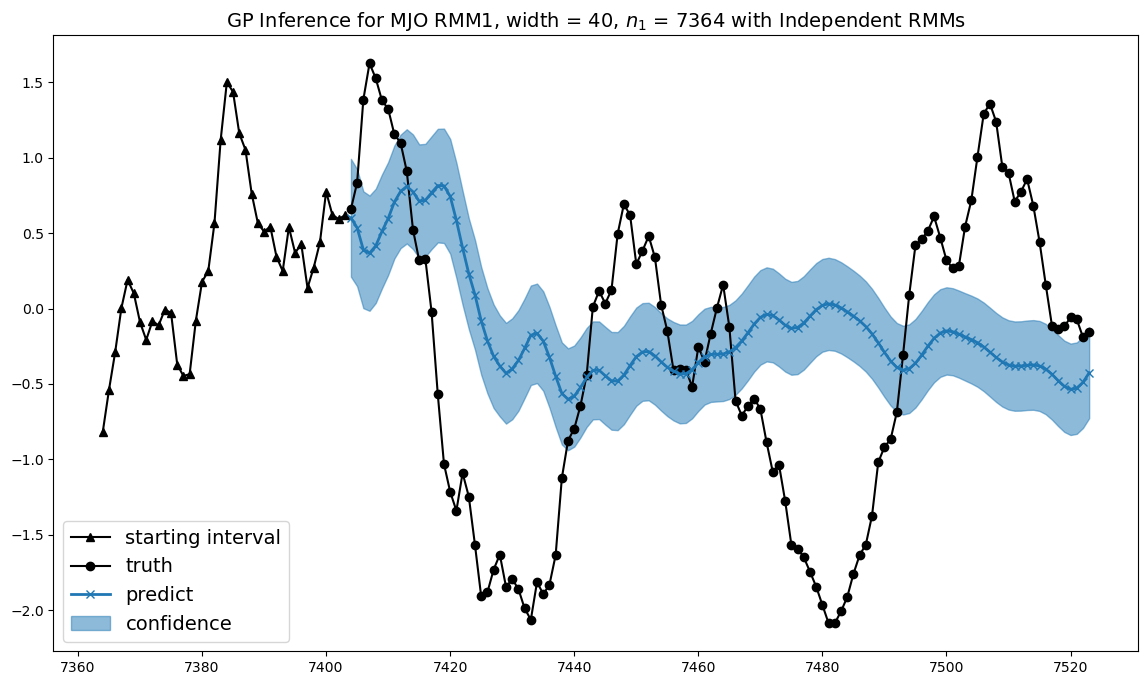

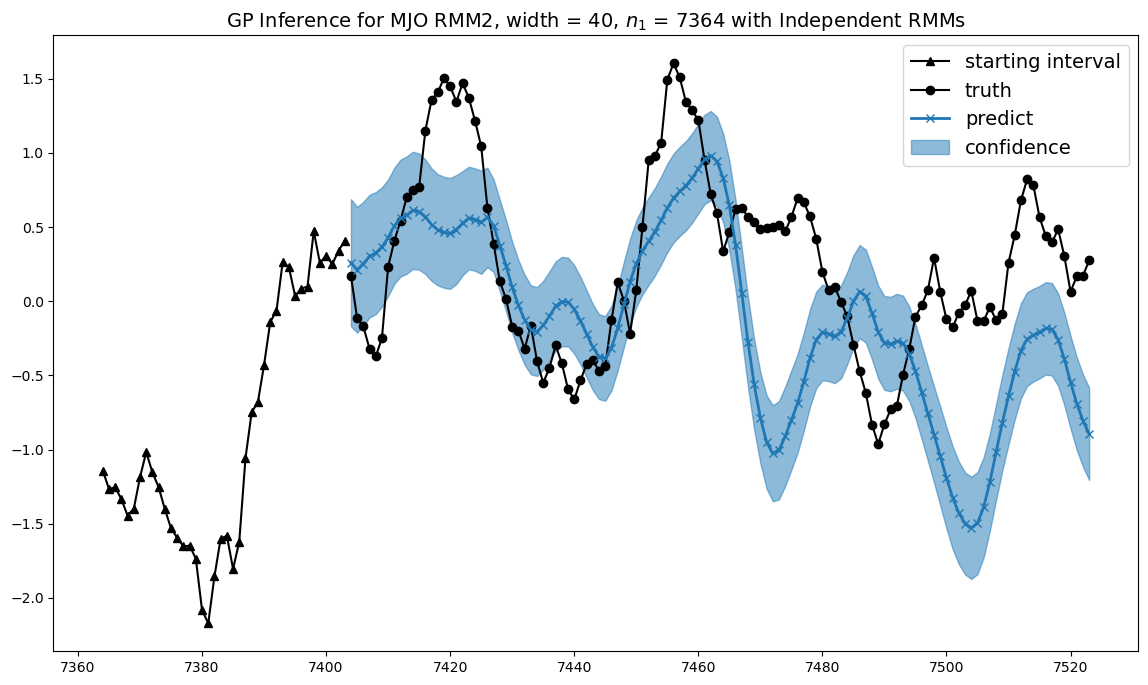

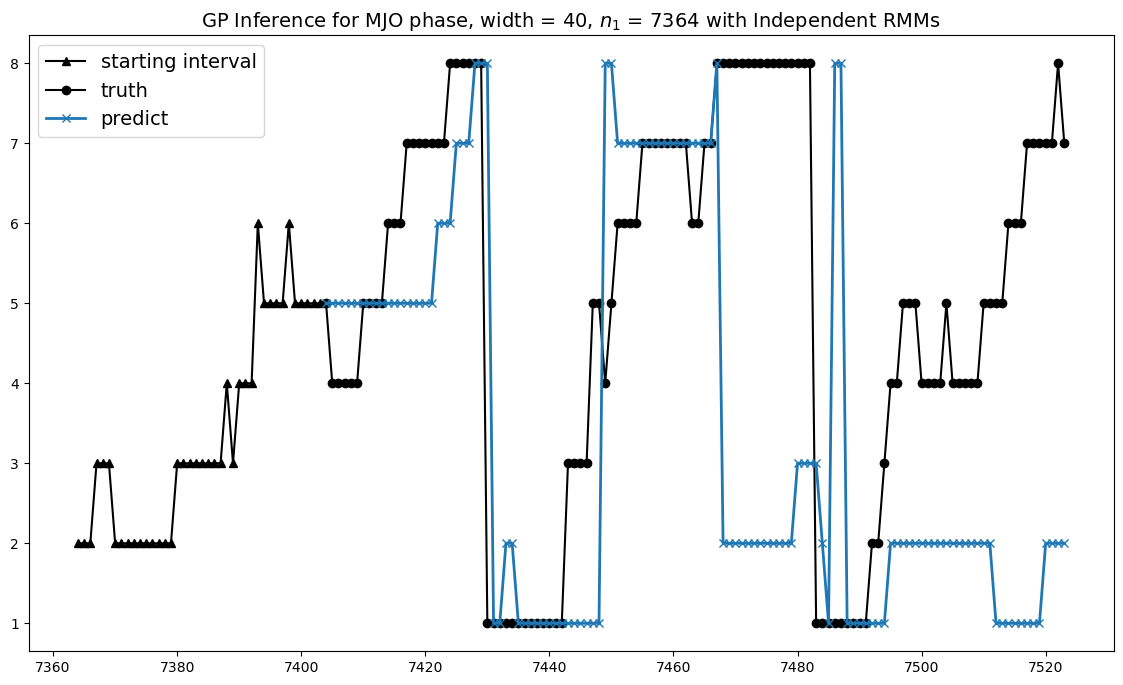

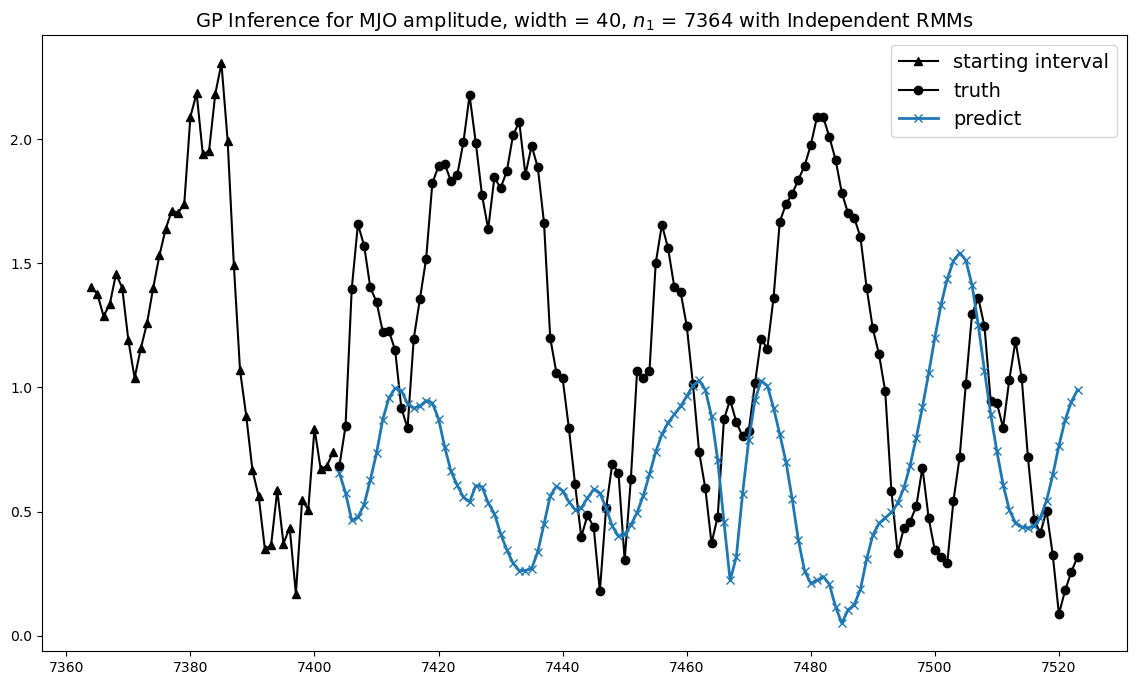

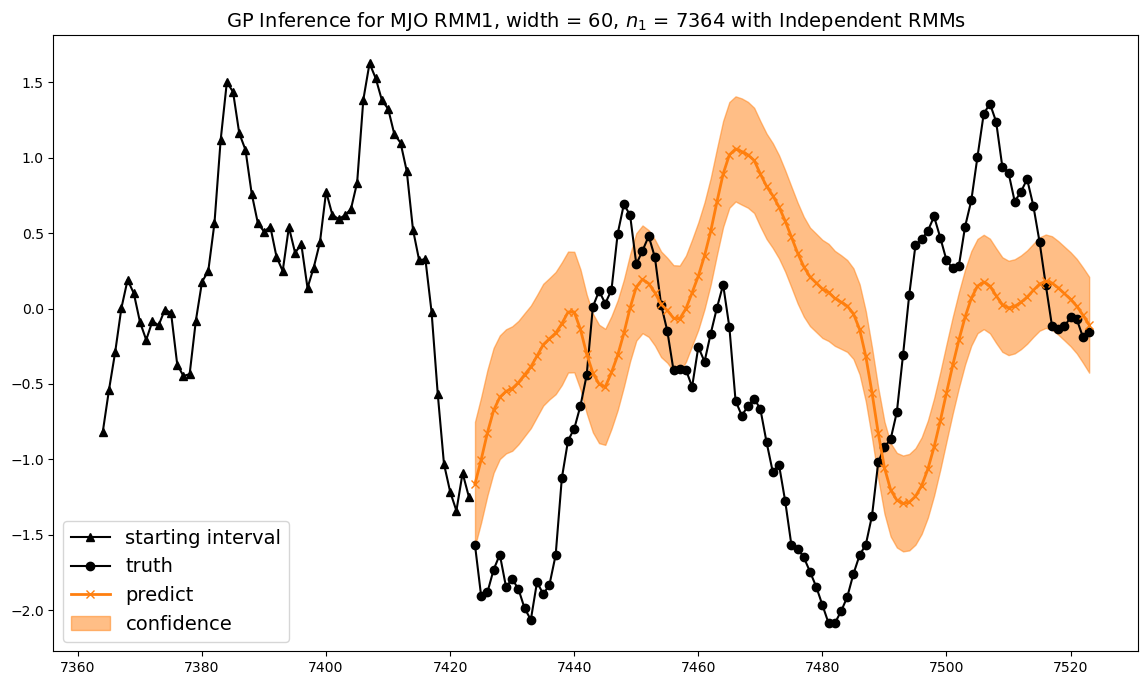

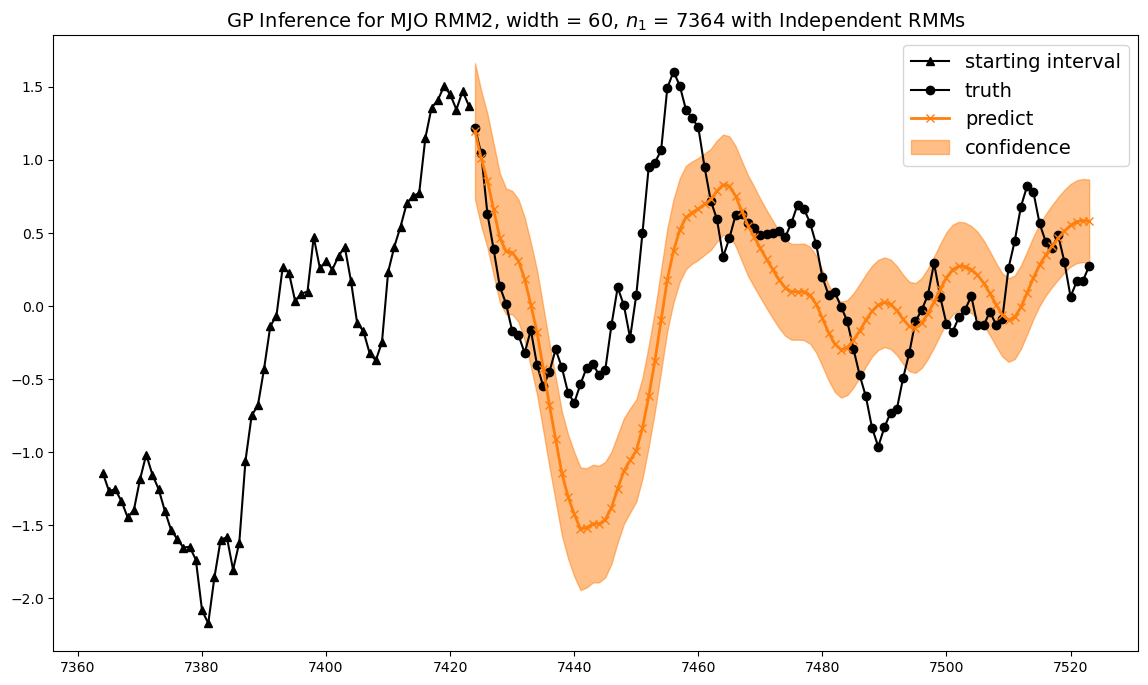

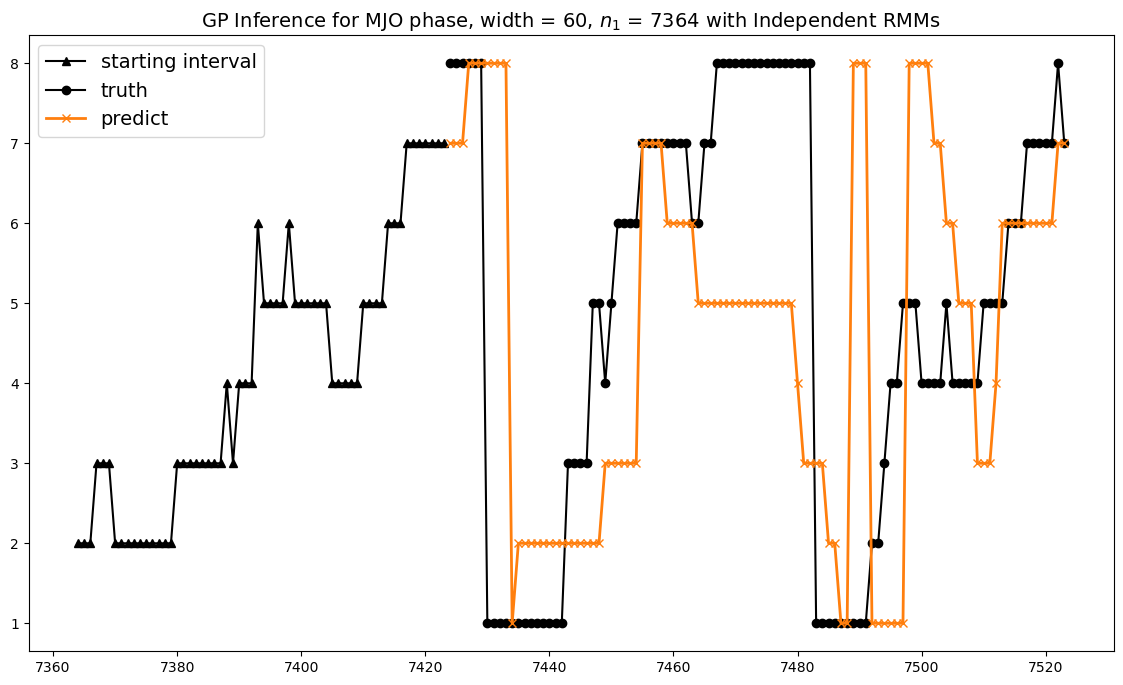

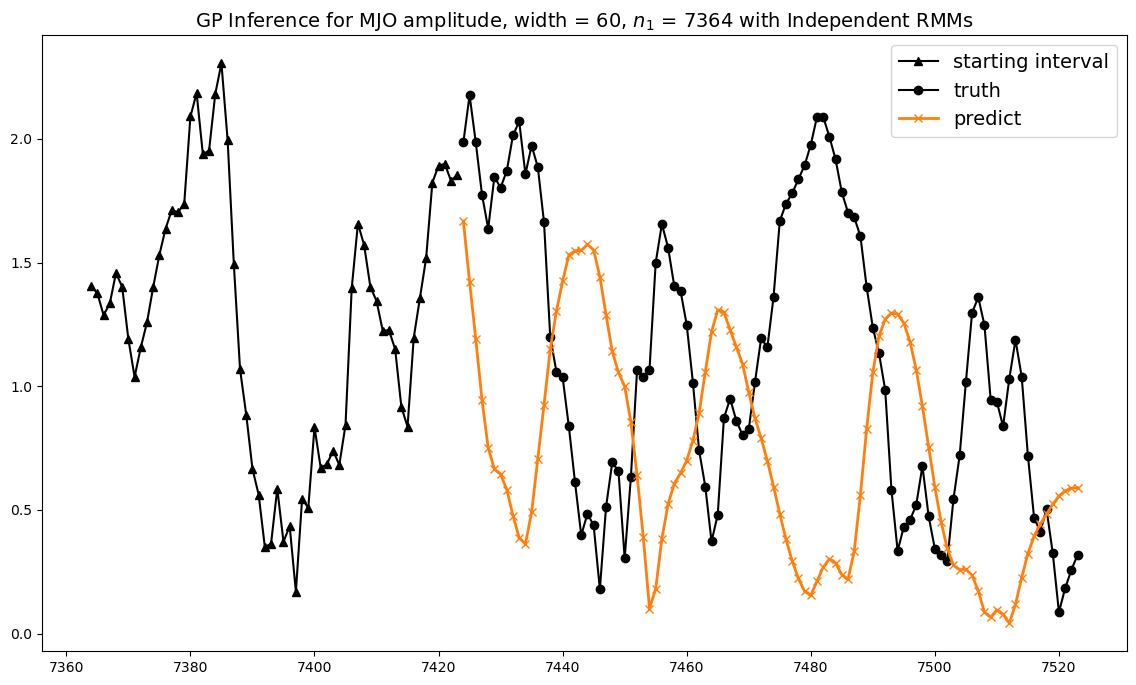

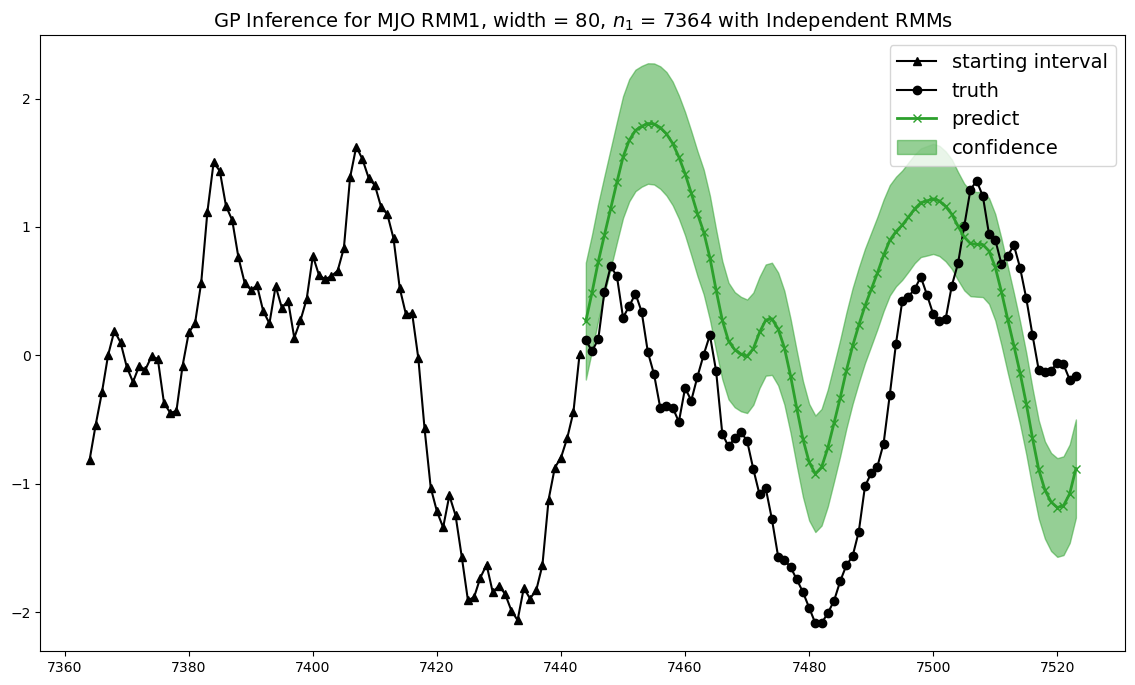

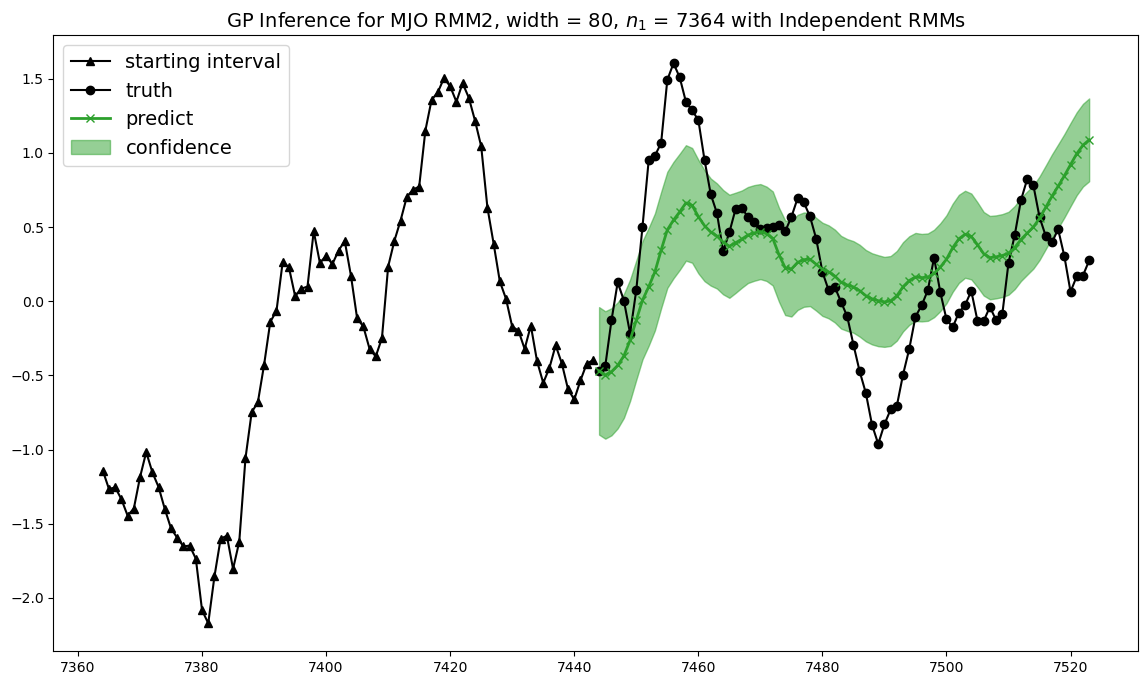

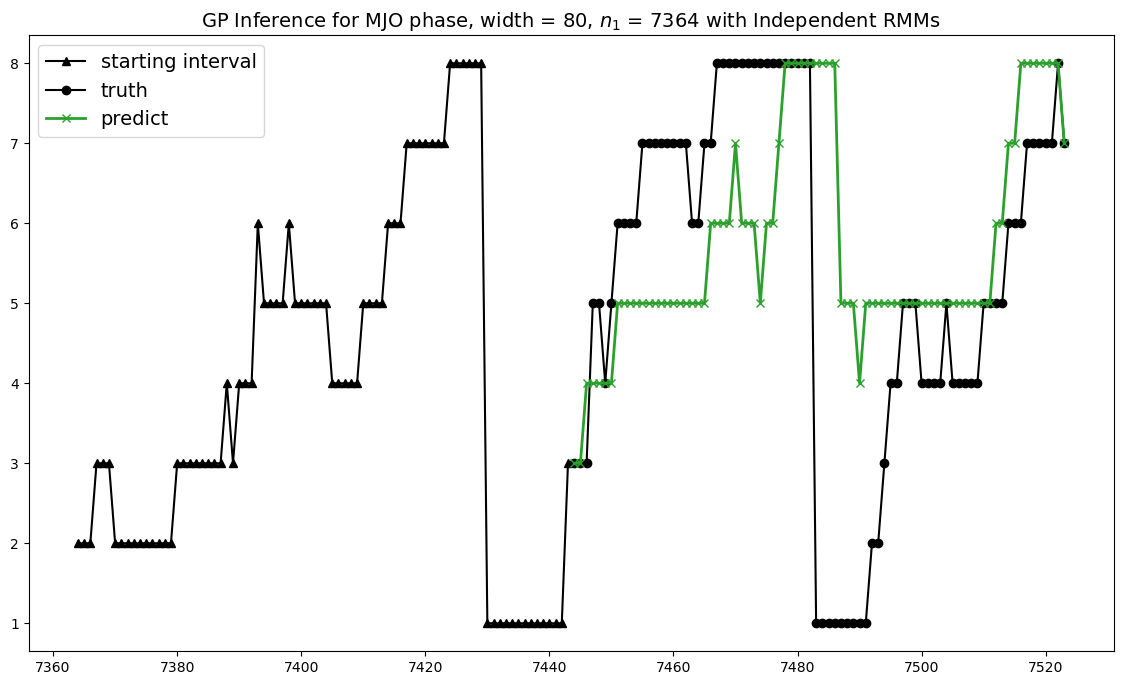

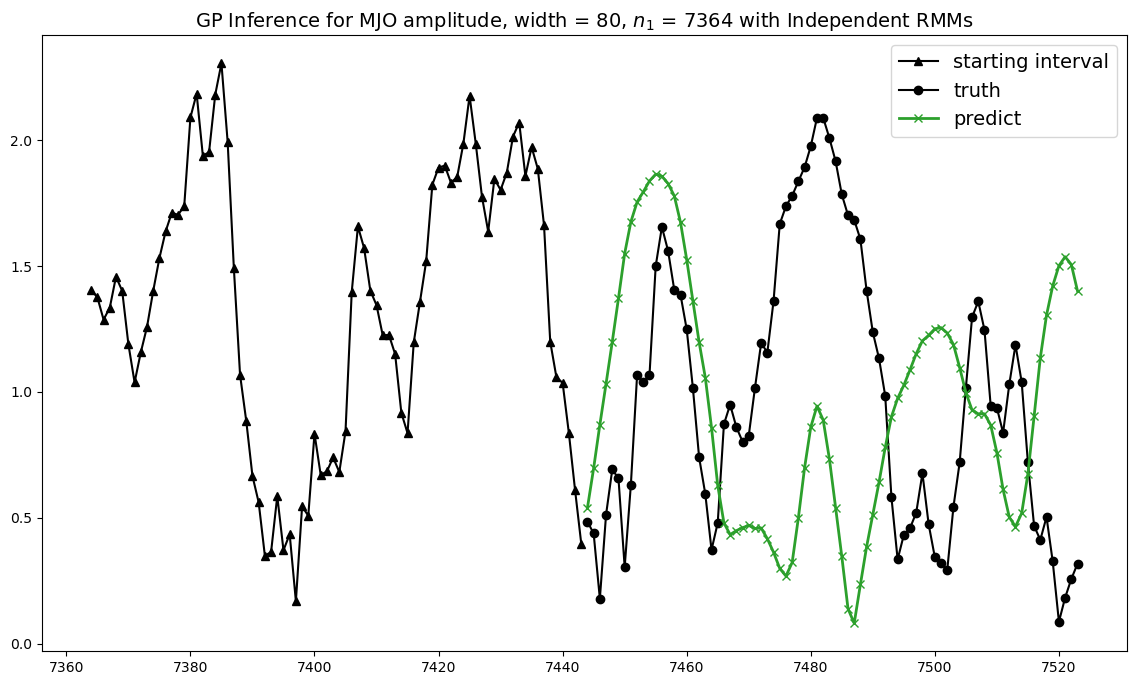

In [4]:
## Independent RMMs
dics_total = {}
for n1 in n1s:
    dics, dics_ids = dics_divide(new_datas, data_names, n1, m, n, c)
    dics_total[n1] = dics
    for width, color in zip(widths, plot_colors):
        mjo_model = gp_mjo(dics, dics_ids, kernel, width, n_iter, sigma_eps,fixed_noise)
        for i in range(4):  # data_names = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
            data_name = data_names[3:][i]
            # initialize plot
            fig, ax = plt.subplots(1, 1, figsize=(14, 8))            
            
            if i <= 1:
                mjo_model.train_mjo(data_name)
                mjo_model.pred_mjo(data_name)
            if i == 2:
                mjo_model.rmm_to_phase()
            if i == 3:
                mjo_model.rmm_to_amplitude()
            mjo_model.plot_mjo(data_name, ax, color)

            ax.set_title(f'GP Inference for MJO {data_name}, width = {width}, $n_1$ = {n1} with Independent RMMs',fontsize=14)
            plt.show()